Imputed Log Reg with Fairness Constraints

In [2]:
import pandas as pd
from train_eval_functions import *
import importlib
import joblib


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.1.3 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/traitlets/config/application.py", line 1075, in launch_instance
    app.start()
  File "/Users/zengsimon/miniconda3/envs/hrs/lib/python3.12/site-packages/ipykernel/kernelapp.py", line 739, in start
  

In [4]:
#defining all load data scenarios
from sklearn.model_selection import train_test_split
from collections import defaultdict 

def check_if_better(current_sp, current_eo, current_max_gap, best_sp, best_eo, best_max_gap, tolerance=0.01):
    improved_sp = abs(current_sp) < abs(best_sp) - tolerance
    improved_eo = abs(current_eo) < abs(best_eo) - tolerance
    improved_max_gap = abs(current_max_gap) < abs(best_max_gap) - tolerance
    return improved_sp or improved_eo or improved_max_gap

def stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200):
    train_class_distribution = train_df['mortality_ten_years'].value_counts(normalize=True)
    rounded_distribution = (train_class_distribution * 100).round().astype(int)
    #print(rounded_distribution)
    #print(id_test_df['mortality_ten_years'].value_counts(normalize=True))
    #print(ood_test_df['mortality_ten_years'].value_counts(normalize=True))

    id_test_df = stratified_sample(id_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)
    ood_test_df = stratified_sample(ood_test_df, target_col='mortality_ten_years', n_samples=n_samples, class_distribution=rounded_distribution)

    return train_df, id_test_df, ood_test_df

def fill_na_val(train_df, id_test_df, ood_test_df):
    train_df = train_df.fillna(-999)
    id_test_df = id_test_df.fillna(-999)
    ood_test_df = ood_test_df.fillna(-999)

    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def impute(train_df, id_test_df, ood_test_df):
    imp_norm_pipe = Pipeline(steps=[
            ("imputer", SimpleImputer(strategy="mean",missing_values=pd.NA)),
            ("normalizer", StandardScaler())])
    
    X_train, y_train = split_dataset_into_x_y(train_df, 'mortality_ten_years')
    X_id_test, y_id_test = split_dataset_into_x_y(id_test_df, 'mortality_ten_years')
    X_ood_test, y_ood_test = split_dataset_into_x_y(ood_test_df, 'mortality_ten_years')

    all_na_cols = X_train.columns[X_train.isna().all()]
    X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)  
    X_train = pd.DataFrame(imp_norm_pipe.fit_transform(X_train), columns=X_train.columns, index=X_train.index)

    X_id_test = X_id_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_id_test = pd.DataFrame(imp_norm_pipe.transform(X_id_test), columns=X_id_test.columns, index=X_id_test.index)

    X_ood_test = X_ood_test.drop(columns=all_na_cols).fillna(np.nan)  
    X_ood_test = pd.DataFrame(imp_norm_pipe.transform(X_ood_test), columns=X_ood_test.columns, index=X_ood_test.index)

    return X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test

def load_data_scenario_1(imputed=False):
    '''
    Train: 2006-2010
    ID Test: 2012
    OOD Test: 2014-2016
    '''

    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    id_test_df = data_dict['2012']
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)

    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_2(imputed=False):
    '''
    Train: 2006-2008
    ID Test: 2010-2012
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    train_df = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    id_test_df = pd.concat([data_dict['2010'], data_dict['2012']], ignore_index=True)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)
    
    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_3(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2006-2010 (20%)
    OOD Test: 2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]
    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_4(imputed=False):
    '''
    Train: 2006-2014 (80%) all regions except 11 1 2
    ID Test: 2006-2014 (20%) all regions except 11 1 2
    OOD Test: 2016. 11, 1, 2
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')
    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)

    dataset.drop(dataset[dataset['state_live_current'].isin([97, 98, 99, 11, 1, 2])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = data_dict['2016']
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([11, 1, 2])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_5(imputed=False):
    '''
    Train: 2006-2016 (80%) regions 3, 4, 5, 6
    ID Test: 2006-2016 (20%) regions 3, 4, 5, 6
    OOD Test: 2006-2016 region 1
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    dataset.drop(dataset[dataset['race'].isin([-999, 8, 9, 2, 7])].index, inplace=True)

    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test, y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
    ood_test_df.drop(ood_test_df[~ood_test_df['state_live_current'].isin([1])].index, inplace=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

def load_data_scenario_6(imputed=False):
    '''
    Train: 2006-2010 (80%)
    ID Test: 2010-2012 (20%)
    OOD Test: 2014-2016
    '''
    data_dict = pd.read_pickle('cleaned_data_stacked_and_dict.pkl')

    dataset = data_dict['2010']
    X_dataset = dataset.drop(columns=["mortality_ten_years"])
    y_dataset = dataset["mortality_ten_years"]

    X_train, X_id_test, y_train, y_id_test = train_test_split(X_dataset, y_dataset, test_size=0.2, random_state=42)

    dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
    X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
    y_train = pd.concat([dataset["mortality_ten_years"], y_train])

    id_test_df = data_dict['2012']
    X_id_test = pd.concat([id_test_df, X_id_test])
    y_id_test = pd.concat([id_test_df["mortality_ten_years"], y_id_test])

    train_df = pd.concat([X_train, y_train], axis=1)
    id_test_df = pd.concat([X_id_test.drop(columns=["mortality_ten_years"]), y_id_test], axis=1)
    ood_test_df = pd.concat([data_dict['2014'], data_dict['2016']], ignore_index=True)

    train_df, id_test_df, ood_test_df = stratify_wrapper(train_df, id_test_df, ood_test_df, n_samples=200)
    
    if not imputed:
        return fill_na_val(train_df, id_test_df, ood_test_df)
    else:
        return impute(train_df, id_test_df, ood_test_df)

In [ ]:
def train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test):
    best_sp, best_eo, best_max_gap = float('inf'), float('inf'), float('inf')
    no_improvement_count = 0
    patience = 3  #number of evaluation steps to wait for improvement
    tolerance = 0.01  #min improvement required for each metric

    #X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)
    #EXP_GRAD_SENS_ATTR = "race"
    clf = LogisticRegression(max_iter=100, warm_start=True, random_state=42)
    objective = ErrorRate(costs={'fp': 0.5, 'fn': 0.5})
    #constraint = DemographicParity(difference_bound=0.09) # can be changed to other constraints instead 
    #constraint = EqualizedOdds(difference_bound=0.05)

    ITERATIONS = 100
    EVAL_EVERY = 5

    mitigator = ExponentiatedGradient(clf, constraint, objective=objective, max_iter=ITERATIONS)
    metrics_history = defaultdict(list)

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", category=ConvergenceWarning)
        mitigator.fit(X_train, y_train, sensitive_features=X_train[EXP_GRAD_SENS_ATTR])
        predictors = mitigator.predictors_ 
        weights = mitigator.weights_ 

        for i in range(1, ITERATIONS+1): 
            combined_proba = np.zeros((X_train.shape[0], 2)) 
            for j in range(min(i, len(predictors))): 
                if j >= len(weights):
                    print(f"Skipping iteration {j}, weight not available")
                    continue
                combined_proba += weights[j] * predictors[j].predict_proba(X_train)


            y_train_pred = np.argmax(combined_proba, axis=1)
            acc = accuracy_score(y_train, y_train_pred)
            metrics_history["accuracy"].append(acc)

            if i % EVAL_EVERY == 0:
                sp, eo, max_gap = get_fairness_metrics(
                    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
                    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=True, expo_grad=True
                )
                metrics_history["sp"].append(sp[EXP_GRAD_SENS_ATTR][0])
                metrics_history["eo"].append(eo[EXP_GRAD_SENS_ATTR][0])
                metrics_history["max_gap"].append(max_gap[EXP_GRAD_SENS_ATTR][0])

                if check_if_better(sp[EXP_GRAD_SENS_ATTR][0], eo[EXP_GRAD_SENS_ATTR][0], max_gap[EXP_GRAD_SENS_ATTR][0], best_sp, best_eo, best_max_gap, tolerance=tolerance):
                    best_sp, best_eo, best_max_gap = sp[EXP_GRAD_SENS_ATTR][0], eo[EXP_GRAD_SENS_ATTR][0], max_gap[EXP_GRAD_SENS_ATTR][0]
                    no_improvement_count = 0
                    print("Fairness metrics improved, continuing...")
                else:
                    no_improvement_count += 1
                    print(f"No improvement in fairness metrics for {no_improvement_count} evaluations.")

                # stop early
                if no_improvement_count >= patience:
                    print("Early stopping: No significant improvement in fairness metrics.")
                    break

    evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test) #save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/{save_paths[idx]}_eval.txt")

    iterations = range(1, len(metrics_history["accuracy"]) + 1)
    eval_iterations = range(1, len(metrics_history["sp"]) + 1)
    eval_iterations = [i * EVAL_EVERY for i in eval_iterations]

    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    axes[0, 0].plot(iterations, metrics_history["accuracy"], marker='o', label="Accuracy", color="blue")
    axes[0, 0].set_title("Accuracy Over Iterations")
    axes[0, 0].set_xlabel("Iteration")
    axes[0, 0].set_ylabel("Accuracy")
    axes[0, 0].grid(True)

    axes[0, 1].plot(eval_iterations, metrics_history["sp"], marker='o', label="Statistical Parity", color="green")
    axes[0, 1].set_title("Statistical Parity Difference Over Iterations")
    axes[0, 1].set_xlabel("Iteration")
    axes[0, 1].set_ylabel("Statistical Parity Difference")
    axes[0, 1].grid(True)

    axes[1, 0].plot(eval_iterations, metrics_history["eo"], marker='o', label="Equalized Odds", color="orange")
    axes[1, 0].set_title("Equalized Odds Difference Over Iterations")
    axes[1, 0].set_xlabel("Iteration")
    axes[1, 0].set_ylabel("Equalized Odds Difference")
    axes[1, 0].grid(True)

    axes[1, 1].plot(eval_iterations, metrics_history["max_gap"], marker='o', label="Max Calibration Gap", color="red")
    axes[1, 1].set_title("Max Calibration Gap Over Iterations")
    axes[1, 1].set_xlabel("Iteration")
    axes[1, 1].set_ylabel("Max Calibration Gap")
    axes[1, 1].grid(True)

    plt.tight_layout()
    plt.show()

    return mitigator
    


In [114]:
all_was_dist = []
all_sp = []
all_eo = []
all_max_gap = []

EXP_GRAD_SENS_ATTR = "state_live_current"

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  train_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:47: FutureWarning: Downcasting obje

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.75      0.95      0.84       126
           1       0.85      0.45      0.58        74

    accuracy                           0.77       200
   macro avg       0.80      0.70      0.71       200
weighted avg       0.78      0.77      0.74       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.65      0.95      0.77       126
           1       0.57      0.11      0.18        74

    accuracy                           0.64       200
   macro avg       0.61      0.53      0.48       200
weighted avg   

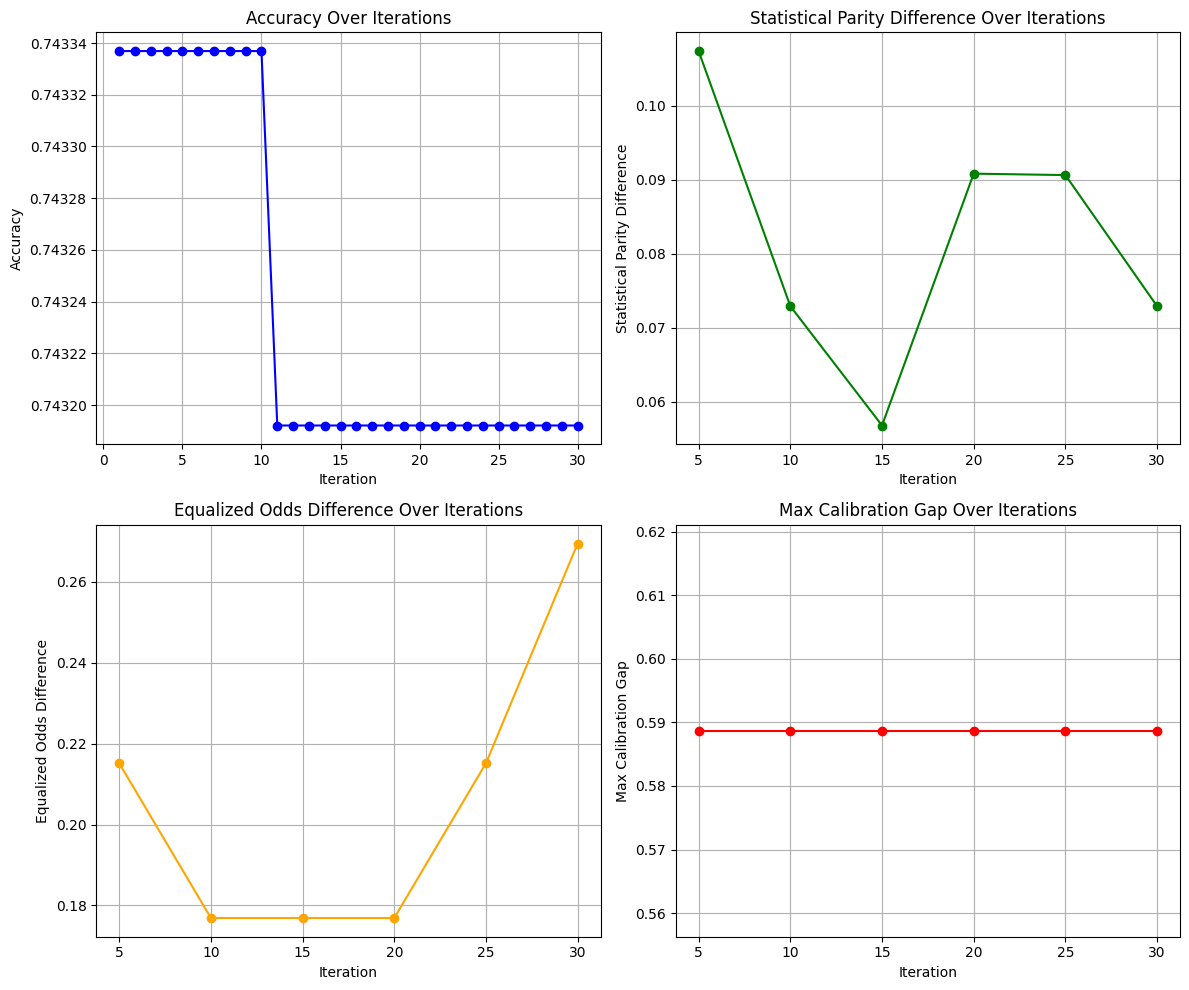

state_live_current:

Statistical Parity Difference (Train): 0.05611138171646993
Equalized Odds Difference (Train): 0.17689331122166946
Max Calibration Gap (Train): 0.5886791475210248

Statistical Parity Difference (ID Test): 0.5
Equalized Odds Difference (ID Test): 0.736842105263158
Max Calibration Gap (ID Test): 0.7688906511586217

Statistical Parity Difference (OOD Test): 0.2222222222222222
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.9105870788273686



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_1(imputed=True)

constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)
        


In [117]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_1_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_1_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.66      0.95      0.78       115
           1       0.82      0.33      0.47        84

    accuracy                           0.69       199
   macro avg       0.74      0.64      0.63       199
weighted avg       0.73      0.69      0.65       199

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.60      0.93      0.73       115
           1       0.62      0.15      0.25        84

    accuracy                           0.60       199
   macro avg       0.61      0.54      0.49       199
we

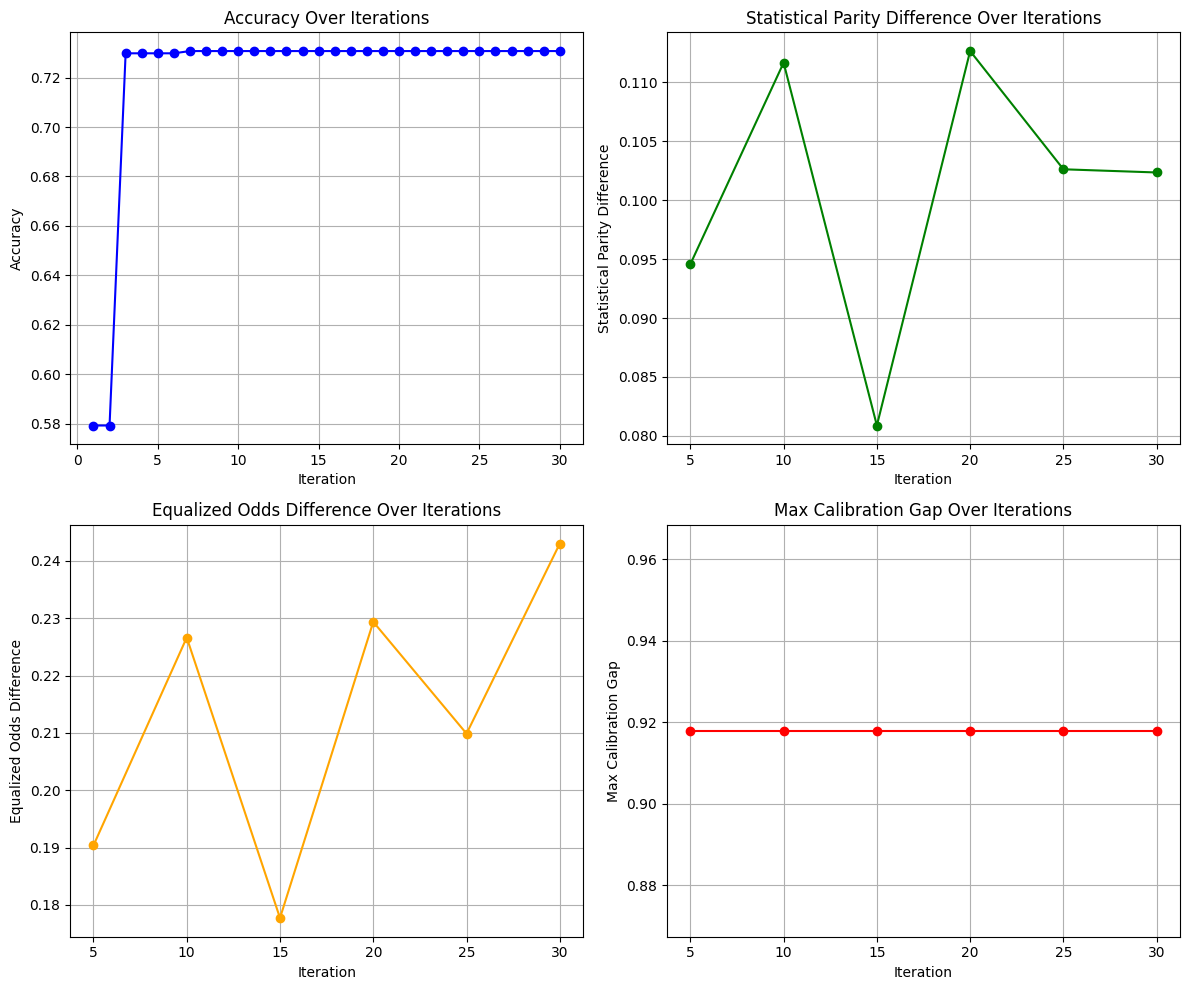

state_live_current:

Statistical Parity Difference (Train): 0.09556071505601438
Equalized Odds Difference (Train): 0.20987056718930866
Max Calibration Gap (Train): 0.9179287116329432

Statistical Parity Difference (ID Test): 0.3125
Equalized Odds Difference (ID Test): 0.5714285714285714
Max Calibration Gap (ID Test): 0.9403833608380149

Statistical Parity Difference (OOD Test): 0.2222222222222222
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.9195000757269225



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_2(imputed=True)

constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [120]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_2_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_2_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:100: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:47: FutureWarning: Downcasting obje

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.75      0.84      0.79       126
           1       0.66      0.53      0.59        74

    accuracy                           0.72       200
   macro avg       0.71      0.68      0.69       200
weighted avg       0.72      0.72      0.72       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.62      0.93      0.75       126
           1       0.25      0.04      0.07        74

    accuracy                           0.60       200
   macro avg       0.44     

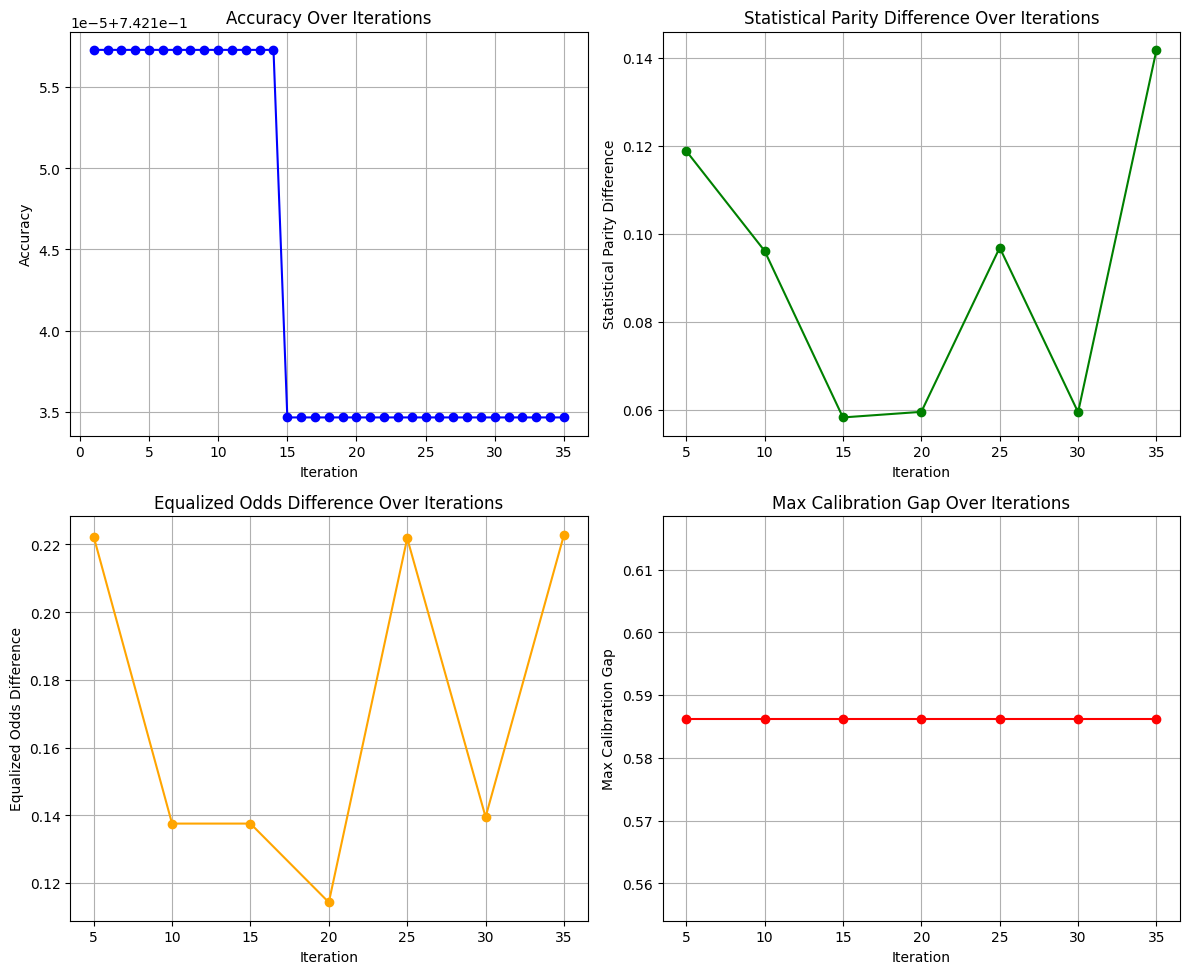

state_live_current:

Statistical Parity Difference (Train): 0.09642857142857142
Equalized Odds Difference (Train): 0.22233676975945016
Max Calibration Gap (Train): 0.5862634714306184

Statistical Parity Difference (ID Test): 0.3728070175438597
Equalized Odds Difference (ID Test): 0.8
Max Calibration Gap (ID Test): 0.9232828895570386

Statistical Parity Difference (OOD Test): 0.3333333333333333
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.8482575278399462



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_3(imputed=True)
constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)


In [123]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_3_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_3_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:123: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:44: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  X_train = X_train.drop(columns=all_na_cols).fillna(np.nan)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.79      0.92      0.85       140
           1       0.70      0.43      0.54        60

    accuracy                           0.78       200
   macro avg       0.75      0.68      0.69       200
weighted avg       0.76      0.78      0.76       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.70      0.99      0.82       140
           1       0.33      0.02      0.03        60

    accuracy                           0.69       200
   macro avg       0.52      0.50      0.43       200
weighted avg       0.59      0.69      0.58       200



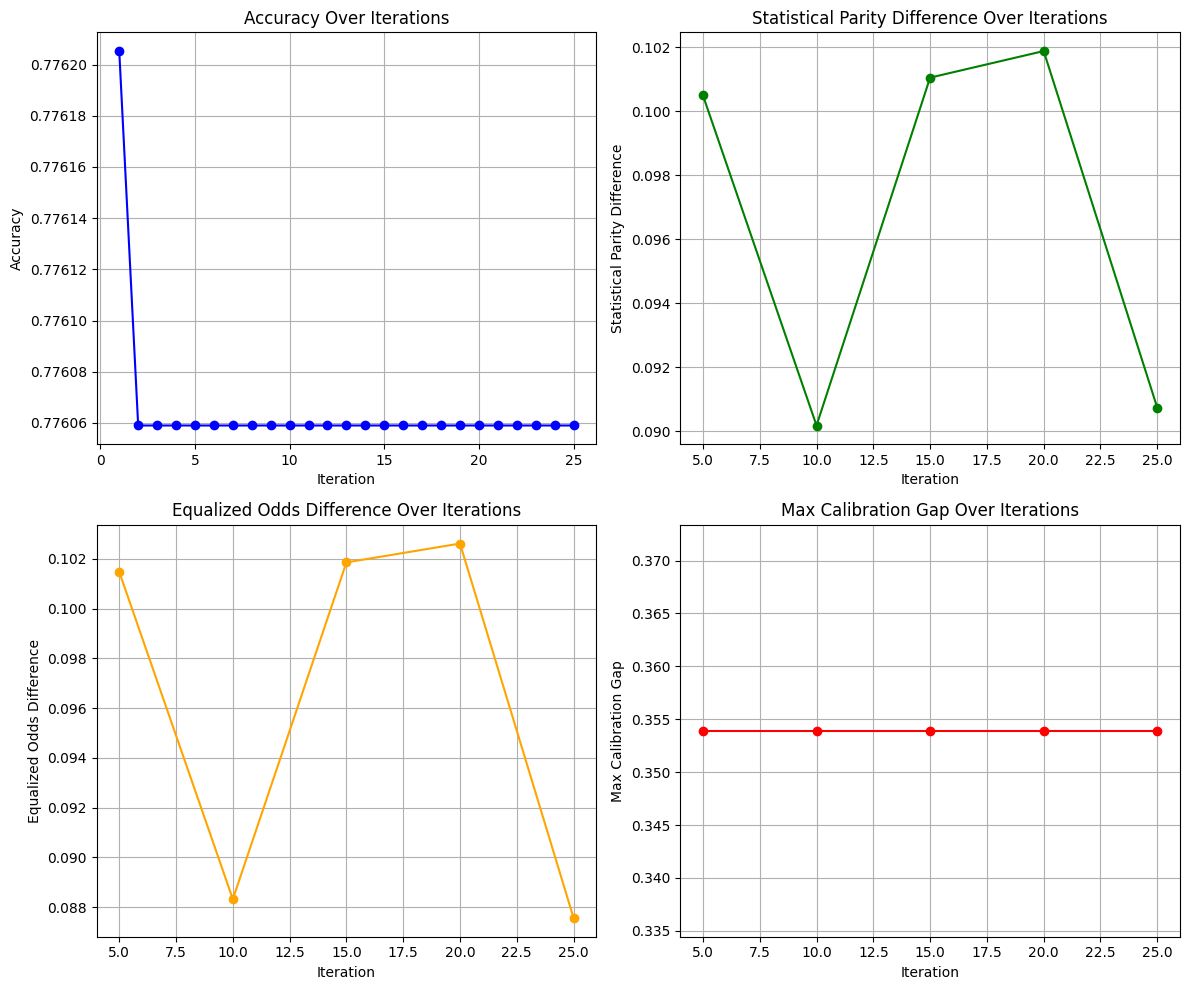

state_live_current:

Statistical Parity Difference (Train): 0.10022148394241417
Equalized Odds Difference (Train): 0.10071942446043164
Max Calibration Gap (Train): 0.3539134802430044

Statistical Parity Difference (ID Test): 0.14301865460712268
Equalized Odds Difference (ID Test): 0.380952380952381
Max Calibration Gap (ID Test): 0.8124234126370824

Statistical Parity Difference (OOD Test): 0.029411764705882353
Equalized Odds Difference (OOD Test): 0.045454545454545456
Max Calibration Gap (OOD Test): 0.8693359186856162



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_4(imputed=True)
    
constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [126]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_4_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_4_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:152: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], data_dict['2012'], data_dict['2014'], data_dict['2016']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:162: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ood_test_df = pd.concat([data_dict['2006'], data_dict['2008'], data_dict['2010'], dat

Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.80      0.94      0.86       146
           1       0.69      0.37      0.48        54

    accuracy                           0.79       200
   macro avg       0.75      0.65      0.67       200
weighted avg       0.77      0.79      0.76       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.79      0.97      0.87       146
           1       0.81      0.31      0.4

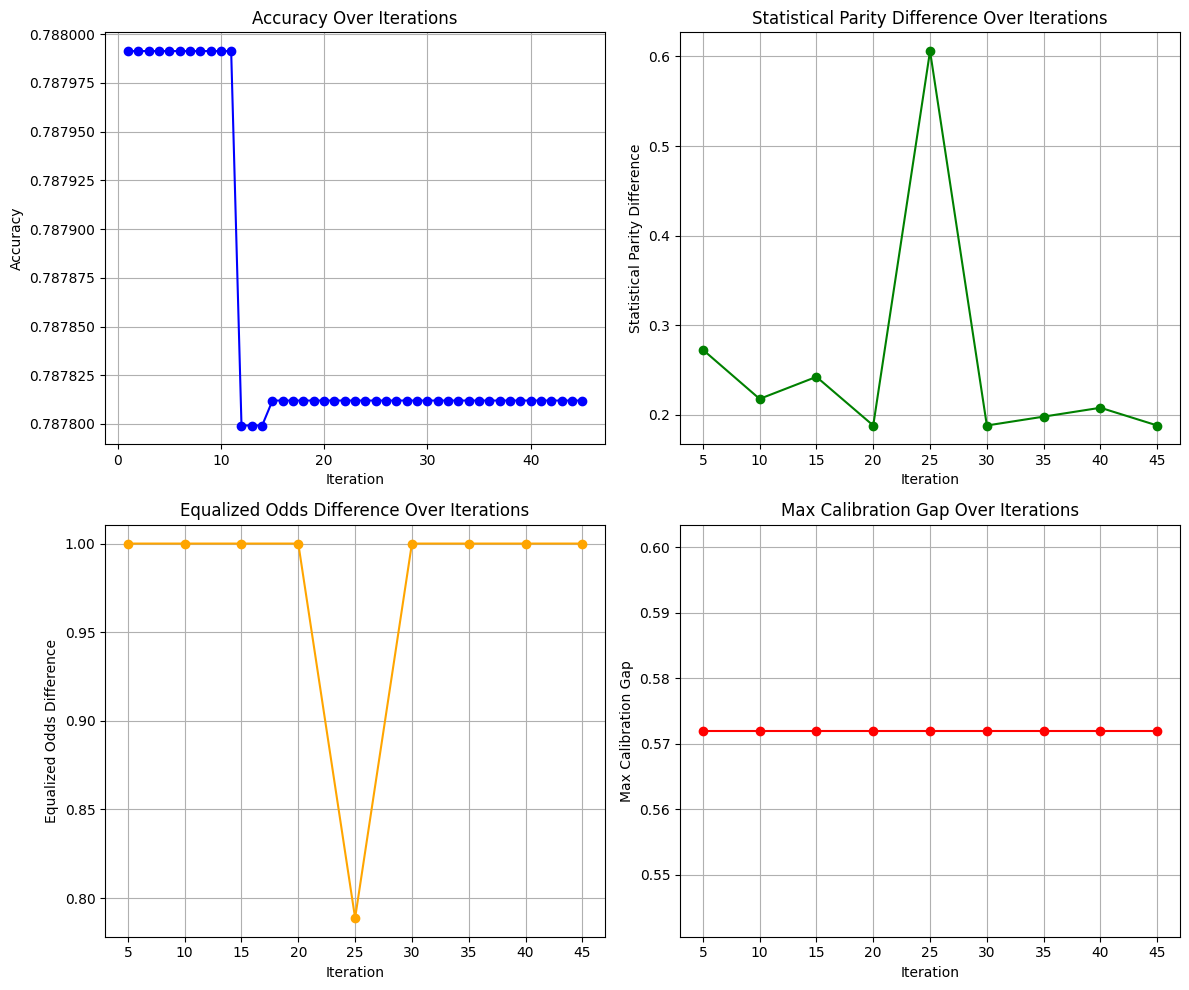

state_live_current:

Statistical Parity Difference (Train): 0.303030303030303
Equalized Odds Difference (Train): 1.0
Max Calibration Gap (Train): 0.5719759693660453

Statistical Parity Difference (ID Test): 1.0
Equalized Odds Difference (ID Test): 1.0
Max Calibration Gap (ID Test): 0.711671671405477

Statistical Parity Difference (OOD Test): 0.0
Equalized Odds Difference (OOD Test): 0.0
Max Calibration Gap (OOD Test): 0.20431789654382704



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_5(imputed=True)

constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)
        


In [129]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_5_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_5_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:186: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  dataset = pd.concat([data_dict['2006'], data_dict['2008']], ignore_index=True)
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:187: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  X_train = pd.concat([dataset.drop(columns=["mortality_ten_years"]), X_train])
/var/folders/n8/5kvsh46d3s79pp231h0z4n9w0000gn/T/ipykernel_44228/2246356702.py:44: 

Fairness metrics improved, continuing...
No improvement in fairness metrics for 1 evaluations.
No improvement in fairness metrics for 2 evaluations.
No improvement in fairness metrics for 3 evaluations.
Early stopping: No significant improvement in fairness metrics.
ID Test Results: 
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       124
           1       0.84      0.41      0.55        76

    accuracy                           0.74       200
   macro avg       0.78      0.68      0.69       200
weighted avg       0.77      0.74      0.72       200

OOD Test Results: 
              precision    recall  f1-score   support

           0       0.64      0.96      0.77       124
           1       0.62      0.11      0.18        76

    accuracy                           0.64       200
   macro avg       0.63      0.53      0.47       200
weighted avg       0.63      0.64      0.54       200



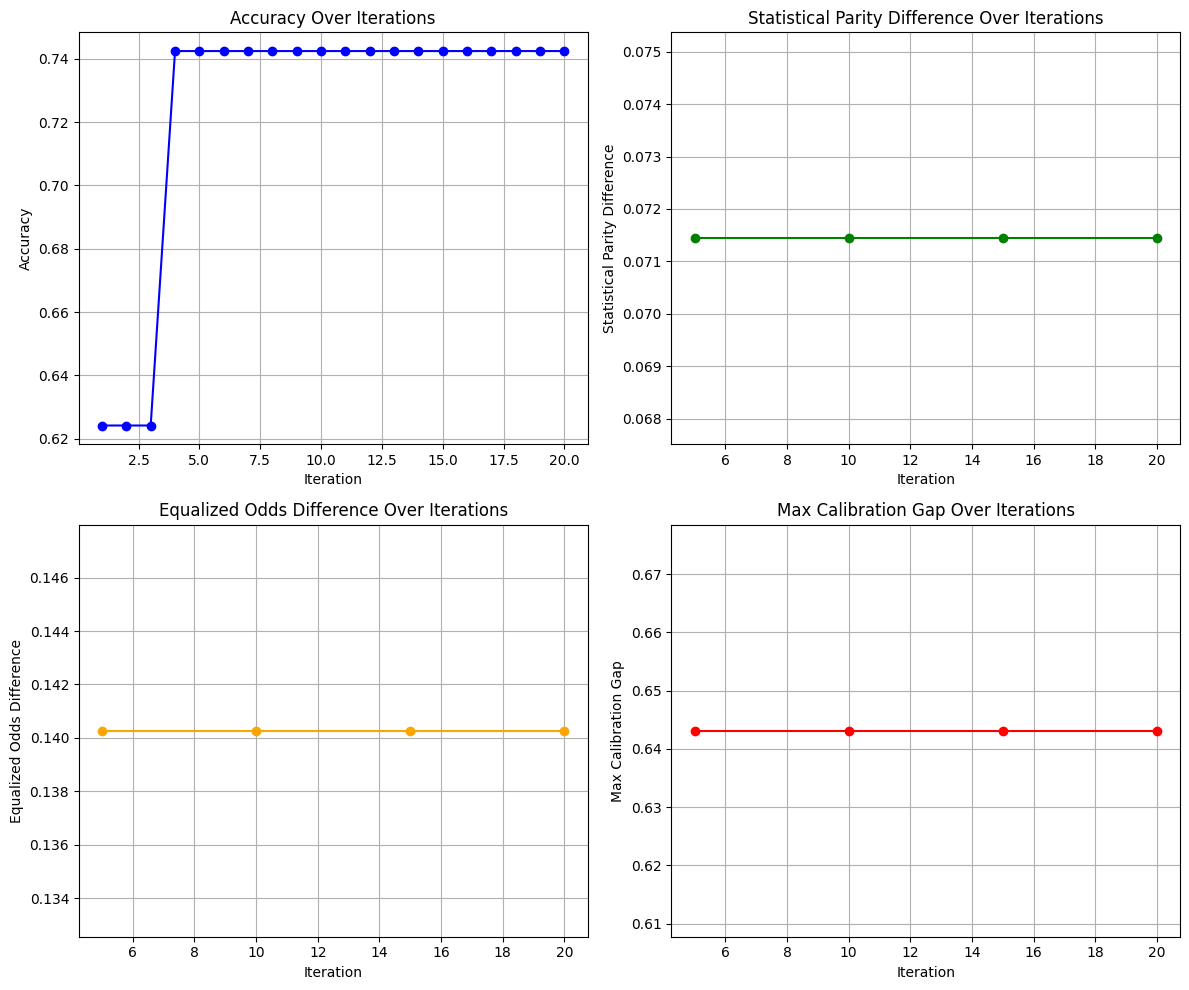

state_live_current:

Statistical Parity Difference (Train): 0.07143985342431133
Equalized Odds Difference (Train): 0.14026438491234516
Max Calibration Gap (Train): 0.6431167769910537

Statistical Parity Difference (ID Test): 0.20075757575757577
Equalized Odds Difference (ID Test): 0.75
Max Calibration Gap (ID Test): 0.8286891902541231

Statistical Parity Difference (OOD Test): 0.16666666666666666
Equalized Odds Difference (OOD Test): 1.0
Max Calibration Gap (OOD Test): 0.9152159959886774



In [ ]:
X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test = load_data_scenario_6(imputed=True)

constraint = DemographicParity(difference_bound=0.07) # can be changed to other constraints instead 
#constraint = EqualizedOdds(difference_bound=0.05)

mitigator = train(EXP_GRAD_SENS_ATTR, constraint, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test)

sp, eo, max_gap = get_fairness_metrics(
    mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test,
    sensitive_attr=EXP_GRAD_SENS_ATTR, mute=False, expo_grad=True
)

In [132]:
evaluate(mitigator, X_id_test, y_id_test, X_ood_test, y_ood_test, save_as=f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_6_eval.txt")
joblib.dump(mitigator, f"./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_grad_imputed_6_weights.pkl")

sp, eo, max_gap = get_fairness_metrics(mitigator, X_train, y_train, X_id_test, y_id_test, X_ood_test, y_ood_test, mute=True, expo_grad=True)
all_sp.append(sp)
all_eo.append(eo)
all_max_gap.append(max_gap)

wd = calculate_wasserstein_distance(X_train, X_id_test, X_ood_test, mute=True)
all_was_dist.append(wd)

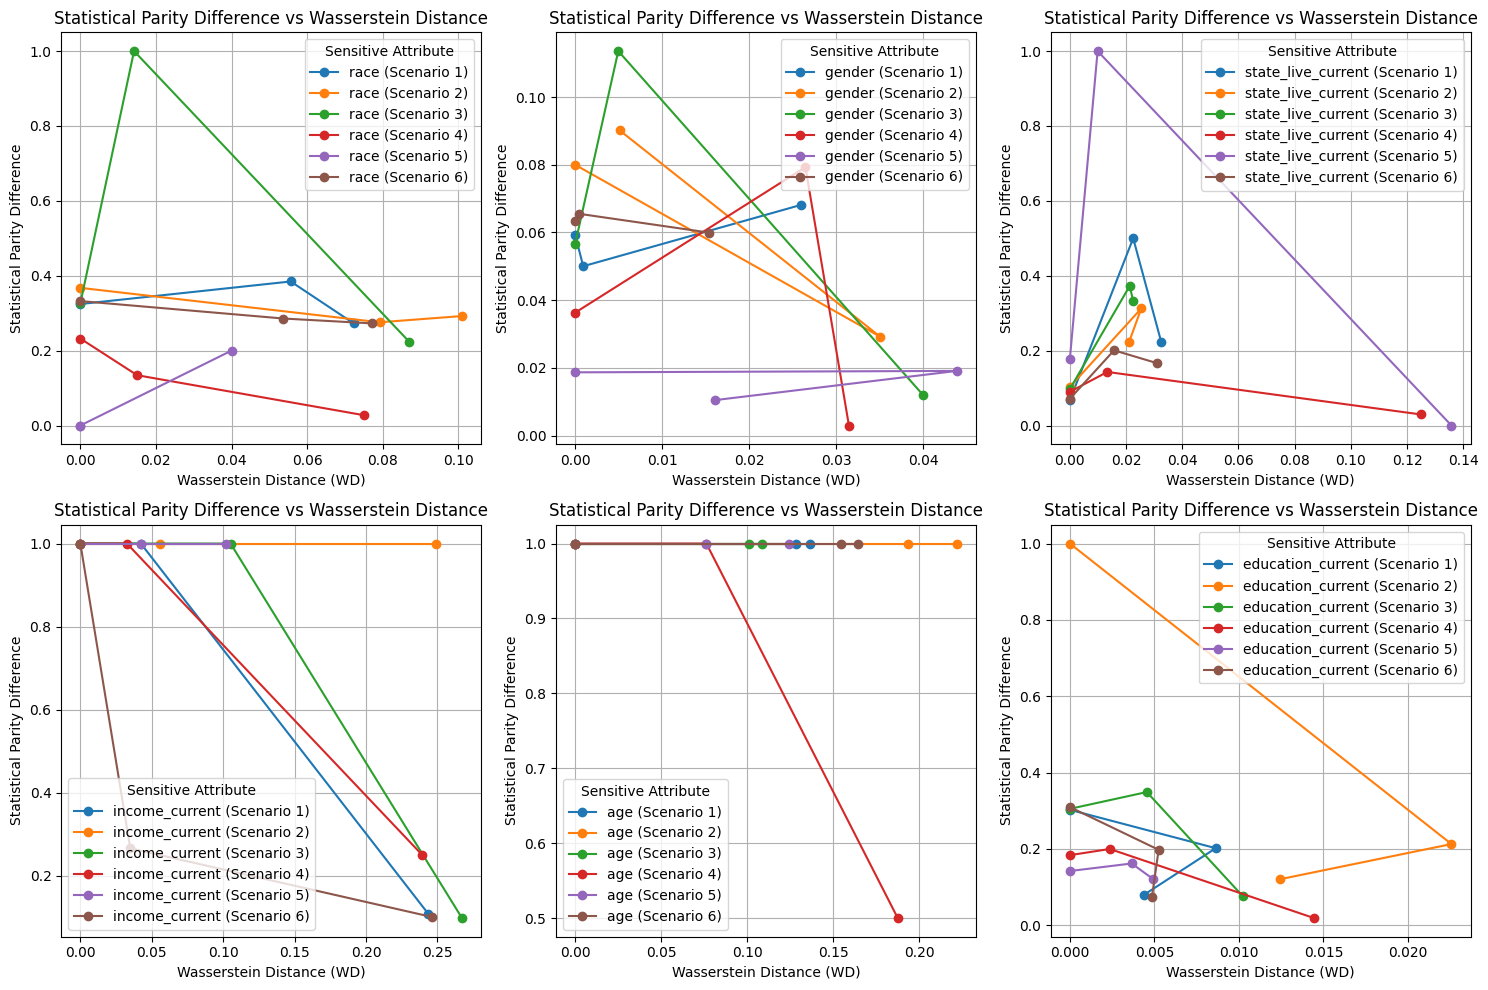

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):  
    attribute = protected_attributes[i]
    for x in range(len(all_sp)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_sp[x][attribute]
        #y_values = [y - y_raw[0] for y in y_raw]
        #ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        y_values = y_raw
        ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Statistical Parity Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Statistical Parity Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

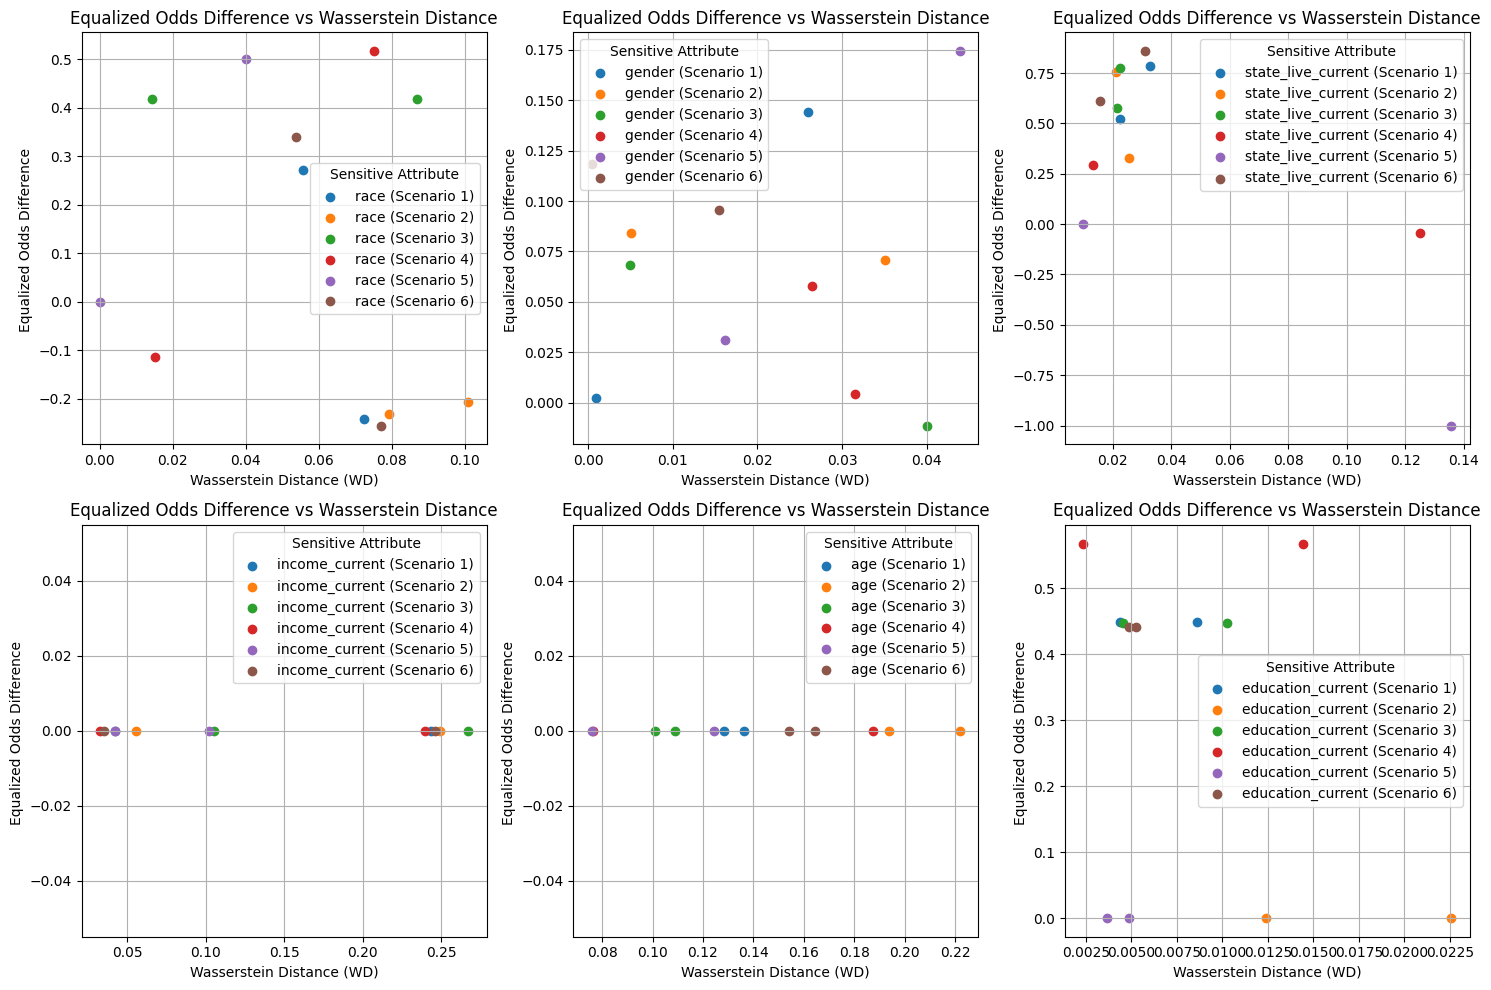

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    attribute = protected_attributes[i]
    for x in range(len(all_eo)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_eo[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Equalized Odds Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Equalized Odds Difference ")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()

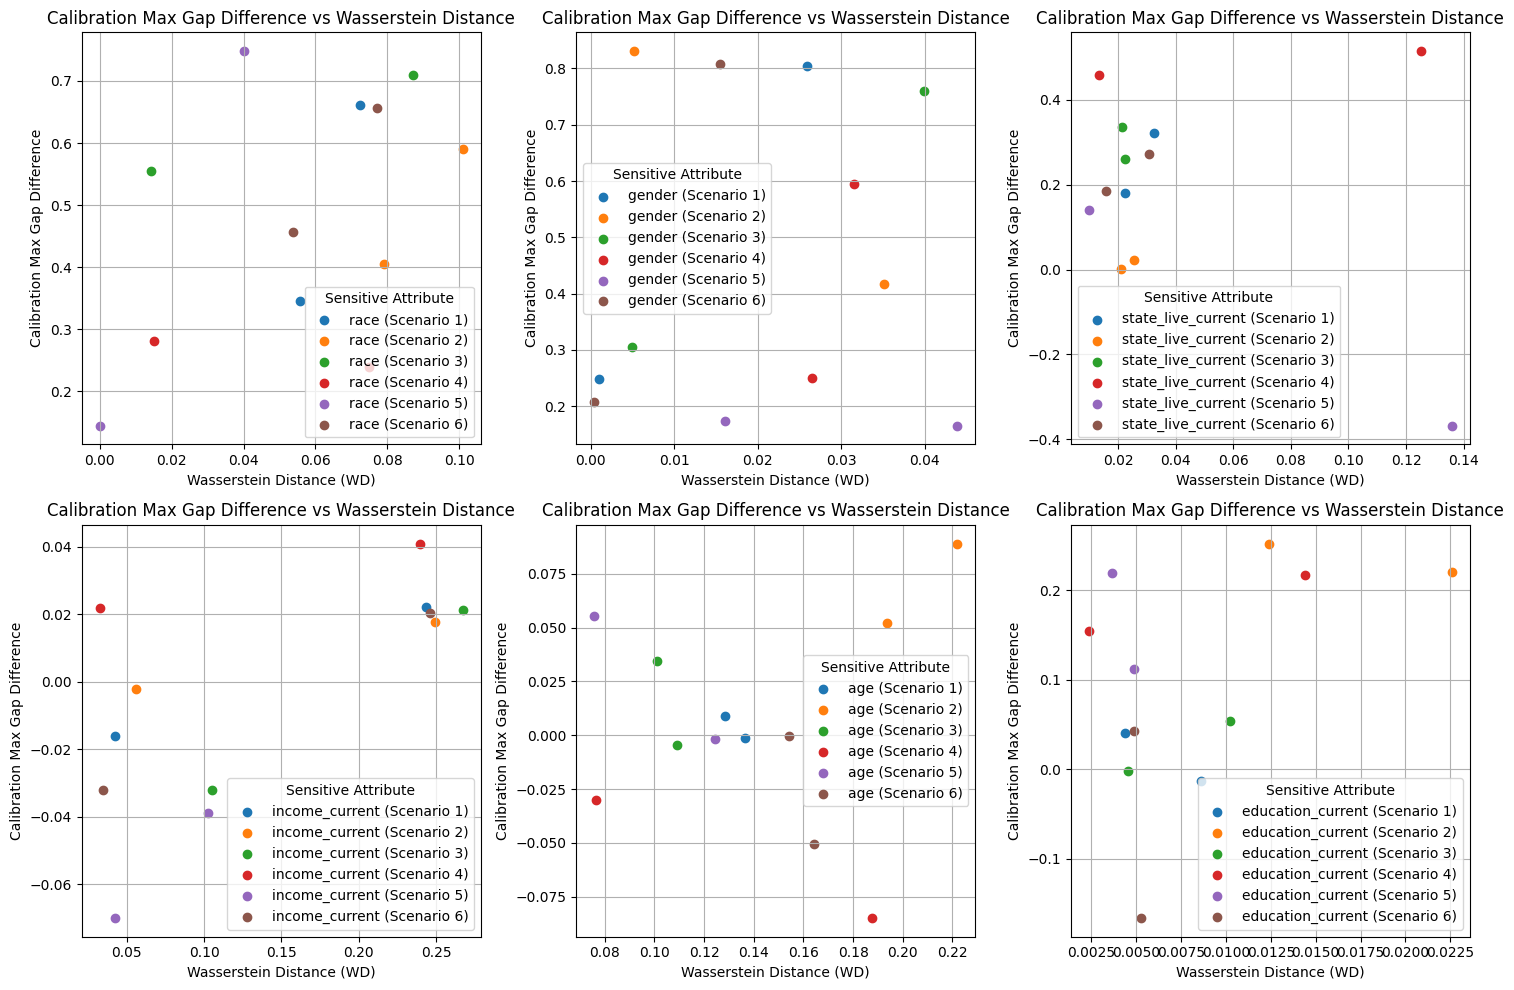

In [ ]:
protected_attributes = ['race', 'gender', 'state_live_current', 'income_current', 'age', 'education_current']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for i, ax in enumerate(axes.flat):
    attribute = protected_attributes[i]
    for x in range(len(all_max_gap)):

        x_values = all_was_dist[x][attribute]
        y_raw = all_max_gap[x][attribute]
        y_values = [y - y_raw[0] for y in y_raw]
        ax.scatter(x_values[1:], y_values[1:], marker='o', label=f"{attribute} (Scenario {x+1})")
        #y_values = y_raw
        #ax.plot(x_values, y_values, marker='o', label=f"{attribute} (Scenario {x+1})")

    ax.set_title(f"Calibration Max Gap Difference vs Wasserstein Distance")
    ax.set_xlabel("Wasserstein Distance (WD)")
    ax.set_ylabel("Calibration Max Gap Difference")
    ax.legend(title="Sensitive Attribute")
    ax.grid(True)

plt.tight_layout()
plt.show()


In [136]:
#save

import pickle

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_was_dist.pkl', 'wb') as file:
    pickle.dump(all_was_dist, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_sp.pkl', 'wb') as file:
    pickle.dump(all_sp, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_eo.pkl', 'wb') as file:
    pickle.dump(all_eo, file)

with open(f'./exponentiated_gradient_imputed/{EXP_GRAD_SENS_ATTR}/exponentiated_gradient_imputed_max_gap.pkl', 'wb') as file:
    pickle.dump(all_max_gap, file)